<a href="https://colab.research.google.com/github/MarioAvolio/Question-Answering-QA-System-for-Customer-Reviews/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [2]:
# https://docs.haystack.deepset.ai/docs/installation

# !git clone https://github.com/deepset-ai/haystack.git
# !cd haystack
# !pip install -e .[all]
!pip install --upgrade pip
!pip install 'farm-haystack[all-gpu]' ## or 'all-gpu' for the GPU-enabled dependencies

In [3]:
!pip install datasets # https://github.com/huggingface/datasets


In [4]:
# !pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
# !pip install transformers==4.28.0
# !pip install accelerate -U
# from transformers import Trainer, TrainingArguments

import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
import transformers

In [5]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [6]:







PATH_PROJ = "/content/drive/MyDrive/AI-proj/"
roberta_base_squad2_distilled = "deepset/roberta-base-squad2-distilled" # https://huggingface.co/deepset/roberta-base-squad2-distilled
xlm_roberta_large_squad2 = "deepset/xlm-roberta-large-squad2"
tinyroberta_squad2 = "deepset/tinyroberta-squad2"



model_ckpt =  roberta_base_squad2_distilled

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [8]:
PATH_PROJ = "/content/drive/MyDrive/AI-proj/"

# Data

In [9]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains # ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

Building a QA system for the Movies domain.

In [10]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", "movies") # https://huggingface.co/datasets/subjqa

In [11]:
subjqa["train"] # https://huggingface.co/datasets/subjqa/viewer/movies/train

Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
    num_rows: 1369
})

In [12]:
# Like other question answering datasets on the Hub, SubjQA stores the answers to
# each question as a nested dictionary. For example, if we inspect one of the rows in the
# answers column:
print(subjqa["train"]["answers"][10])


{'text': ['It is simply astounding', 'The movie is really shocking and appalling'], 'answer_start': [164, 1518], 'answer_subj_level': [1, 1], 'ans_subj_score': [1.0, 1.0], 'is_ans_subjective': [True, True]}


In [13]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1369
Number of questions in test: 291
Number of questions in validation: 261


In [14]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
263,630428845X,How is the story?,[],[],This has got to be one of the most boring and ...
313,630575067X,How is character?,[the digital characters],[1071],"Like most Star Wars fans, I literally counted ..."


In [15]:
start_idx = sample_df["answers.answer_start"].iloc[1][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[1][0])
sample_df["context"].iloc[1][start_idx:end_idx]

'the digital characters'

In [16]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why", "When","What","Who","Whom","Whose","Which"]


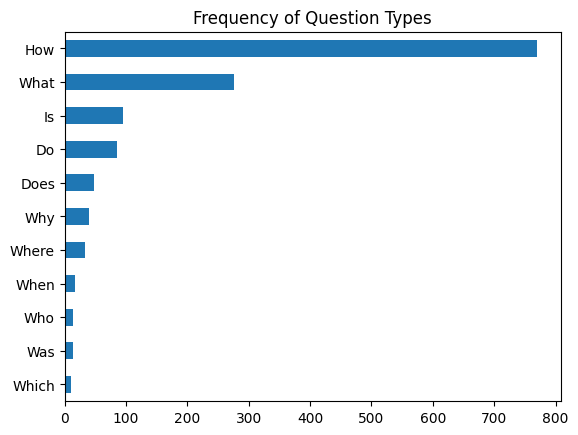

In [17]:
for q in question_types:
  try:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
  except:
    continue
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

We can see that questions beginning with “How”, “What”, and “Is” are the most common ones, so let’s have a look at some examples:

In [18]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the story line?
How is the music?
How can I read the set story at this hotel?
What is the price of the dvd?
What is the really things?
What is the quality of the paint?
Is the main character a good actor?
Is the color better?
Is the actor a funny acting?


## Key Aspects Explored


### Tokenizing


In [19]:
# Transformers provides a convenient AutoTokenizer class that allows you to quickly load
# the tokenizer associated with a pretrained model
# The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to auto‐
# matically retrieve the model’s configuration, pretrained weights, or vocabulary from
# the name of the checkpoint.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path.



To see the model in action, let’s first try to extract an answer from a short passage of
text. In extractive QA tasks, the inputs are provided as (question, context) pairs, so we
pass them both to the tokenizer as follows:

In [20]:
question= "Why is model conversion important?"
context= "The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks."

inputs = tokenizer(question, context)
inputs

{'input_ids': [0, 7608, 16, 1421, 10012, 505, 116, 2, 2, 133, 1973, 7, 10304, 3092, 227, 274, 31874, 8, 7891, 268, 2029, 3519, 7, 5, 3018, 8, 905, 82, 2773, 5405, 227, 32480, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [21]:
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids)
print(tokens)

['<s>', 'Why', 'Ġis', 'Ġmodel', 'Ġconversion', 'Ġimportant', '?', '</s>', '</s>', 'The', 'Ġoption', 'Ġto', 'Ġconvert', 'Ġmodels', 'Ġbetween', 'ĠF', 'ARM', 'Ġand', 'Ġtransform', 'ers', 'Ġgives', 'Ġfreedom', 'Ġto', 'Ġthe', 'Ġuser', 'Ġand', 'Ġlet', 'Ġpeople', 'Ġeasily', 'Ġswitch', 'Ġbetween', 'Ġframeworks', '.', '</s>']


In [22]:
print(tokenizer.convert_tokens_to_string(tokens))

<s>Why is model conversion important?</s></s>The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.</s>


In [23]:
tokenizer.model_input_names, tokenizer.vocab_size, tokenizer.model_max_length

(['input_ids', 'attention_mask'], 50265, 512)

In [24]:
inputs = tokenizer(question, context, return_tensors="pt")

In [25]:
inputs

{'input_ids': tensor([[    0,  7608,    16,  1421, 10012,   505,   116,     2,     2,   133,
          1973,     7, 10304,  3092,   227,   274, 31874,     8,  7891,   268,
          2029,  3519,     7,     5,  3018,     8,   905,    82,  2773,  5405,
           227, 32480,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [26]:
print(tokenizer.decode(inputs["input_ids"][0]))
print(f"Input tensor shape: {inputs['input_ids'].size()}") # As we can see, the resulting tensor has the shape [batch_size, n_tokens]


<s>Why is model conversion important?</s></s>The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.</s>
Input tensor shape: torch.Size([1, 34])


In [27]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 2.1496, -8.3815, -8.9579, -8.5834, -8.9056, -8.4289, -8.7534, -8.8663,
         -8.4358,  2.2718,  0.5388, -0.6111,  0.6512,  0.0475, -2.2790, -2.7140,
         -3.7248, -6.2180, -1.9834, -3.6887,  7.2485,  5.4465, -3.0221, -0.6831,
         -0.1404, -3.1140,  3.3299, -0.7413, -0.9621, -0.5606, -3.1029, -1.8044,
         -0.7706, -2.9905]]), end_logits=tensor([[ 1.7403, -7.6578, -7.9083, -8.0242, -7.2437, -7.5337, -6.7021, -7.4994,
         -8.0321, -5.5748, -3.6861, -5.8051, -5.0949, -3.9377, -6.9967, -5.8674,
         -2.8631, -6.6077, -4.6782, -0.7410, -2.1789,  3.8112, -2.2978, -2.8361,
          6.4149, -2.2741, -3.7446, -2.7129, -2.6549, -2.1933, -3.4658,  5.6136,
          3.5522,  4.4122]]), hidden_states=None, attentions=None)


In [28]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_logits, end_logits

(tensor([[ 2.1496, -8.3815, -8.9579, -8.5834, -8.9056, -8.4289, -8.7534, -8.8663,
          -8.4358,  2.2718,  0.5388, -0.6111,  0.6512,  0.0475, -2.2790, -2.7140,
          -3.7248, -6.2180, -1.9834, -3.6887,  7.2485,  5.4465, -3.0221, -0.6831,
          -0.1404, -3.1140,  3.3299, -0.7413, -0.9621, -0.5606, -3.1029, -1.8044,
          -0.7706, -2.9905]]),
 tensor([[ 1.7403, -7.6578, -7.9083, -8.0242, -7.2437, -7.5337, -6.7021, -7.4994,
          -8.0321, -5.5748, -3.6861, -5.8051, -5.0949, -3.9377, -6.9967, -5.8674,
          -2.8631, -6.6077, -4.6782, -0.7410, -2.1789,  3.8112, -2.2978, -2.8361,
           6.4149, -2.2741, -3.7446, -2.7129, -2.6549, -2.1933, -3.4658,  5.6136,
           3.5522,  4.4122]]))

In [29]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 34])
Start logits shape: torch.Size([1, 34])
End logits shape: torch.Size([1, 34])


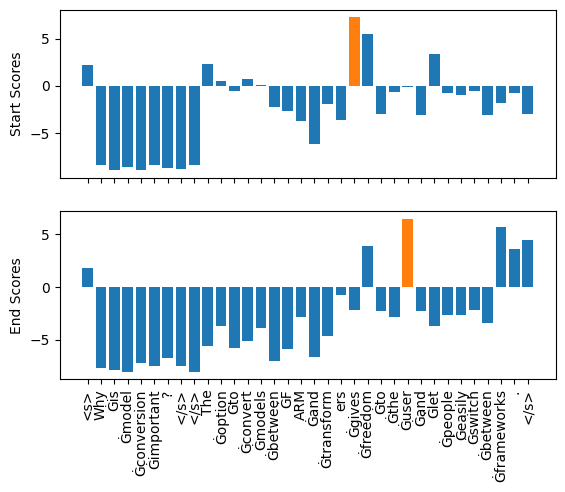

In [30]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens—the token with the highest score is colored in orange

import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

We see that there are two logits (a start and end) associated with each input token. To get the final answer, we can compute the argmax over the start and end token logits and then slice the span from the inputs

In [31]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Why is model conversion important?
Answer:  gives freedom to the user


all of these preprocessing and postprocessing
steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipe‐
line by passing our tokenizer and fine-tuned model as follows:

In [32]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.5217997431755066,
  'start': 59,
  'end': 84,
  'answer': 'gives freedom to the user'},
 {'score': 0.23415370285511017,
  'start': 59,
  'end': 132,
  'answer': 'gives freedom to the user and let people easily switch between frameworks'},
 {'score': 0.08607586473226547,
  'start': 65,
  'end': 84,
  'answer': 'freedom to the user'}]

### Sliding Window Technique


Token indices sequence length is longer than the specified maximum sequence length for this model (801 > 512). Running this sequence through the model will result in indexing errors


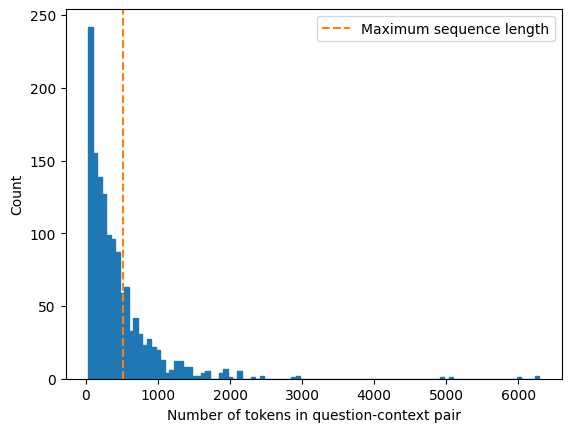

In [33]:
#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [34]:
dfs["train"]#["n_tokens"]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective,n_tokens
0,movies,shocking,movie,brutal,movie,b9ccc5b31d7d8088e2c1ae7c9abd29d3,1,0.00,False,08b48e385ef94c083315a2a48d6dfa3a,4593a383c6b34dc5b3862746cc792675,0310263662,"Well, I have to admit I wasn't expecting to li...",How did you like the movie?,[],[],[],[],[],801
1,movies,more,movie,not perfect,film,83b926f67692aa17ea43ee310e71e798,1,0.00,False,cbcd29b5d19218dc752280689e257940,17d2c3cfd6d27264daadae8c3845e534,0310263662,Controversy.Truth.Faith.Love.Hate.Lies.Confusi...,How is film?,[],[],[],[],[],234
2,movies,brilliant,cinematography,accurate,film,2fe04dea132ab255cf50395b927f2494,1,0.00,False,372bcdad5de05c18d7060a4c5ac0541d,6c49eb603f8d295bf919e7a13d4540e7,0310263662,"""The Passion Of The Christ"" is brilliant and o...",How is film?,"[The film editing by John Wright is brilliant,...","[2189, 1]","[1, 1]","[1.0, 1.0]","[True, True]",724
3,movies,successful,movie,few,thing,47823a869201ab4750286bd6d6805d66,1,0.00,False,e3bc100727cea6a9fe0d05b3e666acc0,53f9e8bee97df42b8e18988c9adc9918,0310263662,I just had a few miscellaneous comments on a f...,How is the thing?,[],[],[],[],[],557
4,movies,good,detail,correct,reviewer,6a96fb8bff576848b1fadfb8b13c0bc6,1,0.00,False,7d5fb1b20bc415221926281621086892,79b2c4aa8c64e898ad28ca95dc4829d6,0310263662,"Say what you want about Mel Gibson, but when h...",How did you like the reviewer?,[],[],[],[],[],1363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,movies,incredible,visual,stunning,movie,82dcd017229185e361cee5dead25166a,1,0.50,False,6844fbc1dbfffc7c08c1c5fc08c6eaff,212846ba95fff9c8f8b43b712bf599c5,B00H83EUL2,I honestly don't feel anything I could say wou...,How many movies should we watch?,[],[],[],[],[],518
1365,movies,incredible,film,fantastic,scene,19c61b234baa35ed560a837ebaf8154c,4,0.75,True,410f4212c4f36ac41cd94c6903000501,9675102114fd62eda4e86bce0393c41a,B00H83EUL2,Good acting and the filming of these outer spa...,Was a great scene film?,"[scenes is incredible, the filming of these ou...","[49, 16]","[2, 2]","[0.9, 0.9]","[True, True]",42
1366,movies,close,movie,little,knowledge,8fd0d01f89d027a2fb9d2aaac76b384b,1,0.00,False,64c655680ae1886066c686a5245701fb,34044bd1d9b4ab12886fd27d3e697c82,B00H83EUL2,My family & I enjoyed this movie. This kept me...,How would you describe my knowledge of Asian c...,[],[],[],[],[],67
1367,movies,worth to watch,film,realistic,movie,95d980d13e4001905698071049d29ea7,1,0.00,False,a8e2edbde0bc2fb82d3f58f09a74caab,9ea155d689207a569540af3d39e341ab,B00H83EUL2,"While the special effects were spectacular, t...",Where we can see this movie?,[],[],[],[],[],121


In [35]:
example = dfs["train"].iloc[0][["question", "context"]]

# we can set return_overflowing_tokens=True in the tokenizer to
# enable the sliding window. The size of the sliding window is controlled by the
# max_seq_length argument, and the size of the stride is controlled by doc_stride
tokenized_example = tokenizer(example["question"], example["context"],
                    return_overflowing_tokens=True, max_length=100,truncation=True,
                    stride=25)

In this case we now get a list of input_ids, one for each window. Let’s check the num‐
ber of tokens we have in each window:

In [36]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 100 tokens
Window #2 has 100 tokens
Window #3 has 100 tokens
Window #4 has 100 tokens
Window #5 has 100 tokens
Window #6 has 100 tokens
Window #7 has 100 tokens
Window #8 has 100 tokens
Window #9 has 100 tokens
Window #10 has 100 tokens
Window #11 has 97 tokens


In [37]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

<s>How did you like the movie?</s></s>Well, I have to admit I wasn't expecting to like this movie, having read all the bad press surrounding it.  But I saw it last night on a whim and I have to say I thought it was fantastic!  Firstly, as a movie it is incredibly well shot.  The scenery is wonderful and the sets are painstakingly recreated - never once do you doubt this is 1st century Palestine.The acting starts off a little</s> 

<s>How did you like the movie?</s></s> sets are painstakingly recreated - never once do you doubt this is 1st century Palestine.The acting starts off a little strained in the garden scene, when the movie is just finding it's feet (and the audience is coming to terms with the fact that the movie isn't some horrible, cheap propaganda short, but a proper movie) but quickly becomes impressive and ends up brutally real.Gibson has set out to make a compelling dram</s> 

<s>How did you like the movie?</s></s> a proper movie) but quickly becomes impressive and ends u

# Constructing a Question-Answering Pipeline Using the Retriever-Reader Architecture


Beginner tutorial: https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline#initializing-the-retriever


## The document store

link: https://www.elastic.co/guide/en/elasticsearch/reference/current/elasticsearch-intro.html

In [38]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [39]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2


# In the Popen() function, the args specify the program we wish to execute, while
# stdout=PIPE creates a new pipe for the standard output and stderr=STDOUT collects
# the errors in the same pipe. The preexec_fn argument specifies the ID of the subpro‐
# cess we wish to use.
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# Wait until Elasticsearch has started
!sleep 31

In [40]:

# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

In [41]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "77667368dd44",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "FsUfA10qTDGL1BhE8Tmd8g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Now that our Elasticsearch server is up and running, the next thing to do is instantiate the document store

In [42]:
from haystack.document_stores import ElasticsearchDocumentStore # https://docs.haystack.deepset.ai/docs/migration

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)


In [43]:
#hide
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [44]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]

    # Since version 1.0 of Haystack, Documents now have a field content, which replaces the field text.
    # This change was introduced because Documents have become more flexible and can also store tables in addition to texts.
    document_store.write_documents(documents=docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1624 documents


## Retriever

In [45]:
# In Haystack 1.4 ElasticsearchRetriever was renamed to BM25Retriever.

from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

Next, let’s look at a simple query for a single movie product in the training set.
For review-based QA systems like ours, it’s important to restrict the queries to a single
item because otherwise the retriever would source reviews about products that are
not related to a user’s query.

In [46]:
item_id = "630575067X" # Star Wars - Episode I, The Phantom Menace VHS
query = "Who is Anakin Skywalker?"

# Each element of retrieved_docs is a Haystack Document
# object that is used to represent documents  and includes the retriever’s query score
# along with other metadata.

retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]}) # Here we’ve specified how many documents to return with the top_k argument and
    # applied a filter on both the item_id and split keys that were included in the meta
    # field of our documents.


In [47]:
print(retrieved_docs[0].to_json())

{"content": "I recently received my copy of the Phantom Menace DVD and am quite pleased with it.  I must say that the sound quality of the DVD is really quite amazing.  The sound and picture quality and special effects alone are worth the price of the DVD.Despite the strengths of the special effects, I must say that the script and the acting are extremely weak at times during the movie.  For example, little 5-year-old Anakin Skywalker hits on the Princess at many times during the movie.  Those scenes are extremely unrealistic.  I just find it really hard to believe that little brat would flirt that much with the adult princess.Also, Anakin Skywalker simply cannot act.  That boy basically reads his lines without much emotion.  I think that the little kid from the 6th Sense would have played a much better Anakin Skywalker.What genius decided that it would be a good idea to have JarJar Binks in almost every scene?  I do understand that JarJar is supposed to provide comic relief.  However,

Now that we have a way to retrieve relevant documents, the next thing we need is a
way to extract answers from them

## Reader


In [48]:
from haystack.nodes import FARMReader

max_seq_length, doc_stride = 384, 128

# In FARMReader, the behavior of the sliding window is controlled by the same
# max_seq_length and doc_stride arguments that we saw for the tokenizer
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True, use_gpu=True)


In [49]:
question, context

('Why is model conversion important?',
 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.')

In [50]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'Why is model conversion important?', 'no_ans_gap': 9.773468494415283, 'answers': [<Answer {'answer': 'gives freedom to the user', 'type': 'extractive', 'score': 0.704782247543335, 'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.', 'offsets_in_document': [{'start': 59, 'end': 84}], 'offsets_in_context': [{'start': 59, 'end': 84}], 'document_ids': ['be82919e80ce1fece28e1a6942ce0d3c'], 'meta': {}}>]}


## Pipeline

In [51]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [52]:
# Each Pipeline has a run() method that specifies how the query flow should be exe‐
# cuted. For the ExtractiveQAPipeline we just need to pass the query, the number of
# documents to retrieve with top_k_retriever, and the number of answers to extract
# from these documents with top_k_reader. In our case, we also need to specify a filter
# over the item ID, which can be done using the filters argument as we did with the
# retriever earlier

n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")


Question: Who is Anakin Skywalker? 

Answer 1: little 5-year-old
Review snippet: ...acting are extremely weak at times during the movie.  For example, little 5-year-old Anakin Skywalker hits on the Princess at many times during the mo...



Answer 2: Darth Vader
Review snippet: ...nto motion. We see the young Anakin Skywalker, who's fate is the evil Darth Vader, but who will eventually bring balance to the Force.Surely these thi...



Answer 3: 
Review snippet: ...None...





In [53]:
# Simplify the printed answers:

from haystack.utils import print_answers

print_answers(preds, details="minimum")  ## Choose from `minimum`, `medium`, and `all`

'Query: Who is Anakin Skywalker?'
'Answers:'
[   {   'answer': 'little 5-year-old',
        'context': 'acting are extremely weak at times during the movie.  For '
                   'example, little 5-year-old Anakin Skywalker hits on the '
                   'Princess at many times during the mo'},
    {   'answer': 'Darth Vader',
        'context': "nto motion. We see the young Anakin Skywalker, who's fate "
                   'is the evil Darth Vader, but who will eventually bring '
                   'balance to the Force.Surely these thi'},
    {'answer': ''}]


# Assessment and Enhancement of the QA Pipeline

In particular, the
retriever sets an upper bound on the performance of the whole QA system, so it’s
important to make sure it’s doing a good job

https://haystack.deepset.ai/tutorials/11_pipelines

## Retriever Evaluation
A common metric for evaluating retrievers is **recall**, which measures the fraction of all
relevant documents that are retrieved. In this context, “relevant” simply means
whether the answer is present in a passage of text or not, so given a set of questions,
we can compute recall by counting the number of times an answer appears in the top
k documents returned by the retriever.



In [54]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [55]:
from haystack import Label, Answer, Document


# Since version 1.0 of Haystack, Answer has become a class and each Label contains a Document that the Label refers to.
# Thus, the initialization of a Label in the following code cell has changed

labels = []
idx_star_wars = None
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}

    # Populate labels for questions with answers
    if len(row["answers.text"]):
        if row["title"] == "630575067X":
          idx_star_wars = len(labels)

        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)




In [56]:
dfs["test"][dfs["test"].title=="630575067X"]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
52,movies,bad,act,atrocious,act,7a5420abde00340d35beeb7875ede9aa,1,0.0,False,8fc5bff3074f0532c6c2d69200cbe4f6,d2a3f690ee7190f2a5deb18493e1f2e1,630575067X,Star Wars Episode 1 would have to go down in f...,How do you find the act of this film?,"[the acting was bad, the acting non-existant]","[666, 144]","[2, 2]","[0.33333334, 0.33333334]","[False, False]"
53,movies,more,character,better,act,b09f0ed55f946fcabfb103e15cb45f30,1,0.0,False,cd2eae81991085bfc8b28b53f3378b42,544ca6f7ac07442823bff52563cb640a,630575067X,I had to reconsider both my original review of...,Where can I see the player act?,[wide-screen DVD],[3649],[1],[0.4],[False]
54,movies,awesome,battle,wooden,performance,df037ee14759c9f261e6850a44faa63b,1,0.0,False,f9925001adcbab4e291883b30983c396,02ac741cab56ac40e37366d2830f6895,630575067X,This is a great addition to the saga. I still...,How did you like the performance?,[],[],[],[],[]
55,movies,excellent,effect,good,visual,7e4b87853cccbf986ce8feefd8d6fed0,2,0.0,False,fccceb1296b0b51cdc3a70ffffbbdfe6,66b9b9e08d203233f82ac3ba4c9b9bf0,630575067X,"The ""Phantom Menace"" discusses the beginnings ...",How is the visual quality of the video?,"[4 stars, The special effects are excellent as...","[343, 140]","[2, 2]","[0.0, 0.0]","[False, False]"
56,movies,great,fight scene,exciting,action scene,4aa53c0b598f84872d20bd779b6ebda4,1,0.1,False,1365edf26c1ac5c84f14bb991e1a4dc8,20d18b71f71efa7ecd527ba67b2a968a,630575067X,This is what DVD's are made for. The plethora...,How was the action scene?,[],[],[],[],[]
57,movies,fantastic,effect,impressive,visual,d3a2536cca9dcccd67ed851dc50d8147,1,0.0,False,12c6b2914cfd01209da7c8cc4a35920f,c2fda2a4bb1c00124a9a00f9b1741348,630575067X,"My, and I believe nearly everyone's favourite ...",How is the visuals of the film?,[Wars&quot;-film a greater emotional impact.&...,[272],[1],[0.9],[True]


In [57]:
def print_label(labels):
  print(f"Query: {labels.query}")

  print(f"Id: {labels.id}")

  print(f"Document: {labels.document}")


  print(f"Answer: {labels.answer}")

  print(f"no_answer: {labels.no_answer}")

print_label(labels[idx_star_wars])

Query: How is the visuals of the film?
Id: addf22f7-8948-4737-8883-f594c6bca5dd
Document: <Document: id=12c6b2914cfd01209da7c8cc4a35920f, content='My, and I believe nearly everyone's favourite &quot;Star Wars&quot;-movie is Episode V-&quot;The Emp...'>
Answer: <Answer: answer='Wars&quot;-film a greater  emotional impact.&quot;The Phantom Menace&quot; is definetly not on par  with that film, nor has it the originality of &quot;A New Hope&quot;, but  still I liked this film a lot. I actually found it better than &quot;Return  Of The Jedi&quot;. Even those who dispised the movie must acknowledge that  it has its merits. The special effects are fantastic, and in contrast to  other films with superior FX', score=None, context=None>
no_answer: False


In [58]:
print(labels[idx_star_wars])

<Label: {'id': 'addf22f7-8948-4737-8883-f594c6bca5dd', 'query': 'How is the visuals of the film?', 'document': {'id': '12c6b2914cfd01209da7c8cc4a35920f', 'content': "My, and I believe nearly everyone's favourite &quot;Star Wars&quot;-movie is Episode V-&quot;The Empire Strikes Back&quot;. Not only because it was visually the most dazzling, it also had far more sense of wonder and magic  than the other Episodes. Never had a &quot;Star Wars&quot;-film a greater  emotional impact.&quot;The Phantom Menace&quot; is definetly not on par  with that film, nor has it the originality of &quot;A New Hope&quot;, but  still I liked this film a lot. I actually found it better than &quot;Return  Of The Jedi&quot;. Even those who dispised the movie must acknowledge that  it has its merits. The special effects are fantastic, and in contrast to  other films with superior FX, they are also highly imaginative because they  create entire worlds of their own. Individual action-setpieces are among  the most 

In [59]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 337 question-answer pairs


In [60]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))


273


In [61]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '6e9aeceb-9795-406d-8c3f-798437394af4', 'query': 'Is the script of the story good in comments?', 'document': {'id': '8108e04e34d4aad31627c2db9910bc41', 'content': "I admit that there are a few things wrong with this film--technical medical things, holes in the plot, and the white trash hillbilly family was unbelievable, over done, and way too dramatic in the two measly scenes that they were in. Still, I loved this film.  I enjoyed every minute of it.  The main characters had depth.  They were not perfect, but loveable and memorable.  The dialogue was good, and the acting was great. On top of all of that, it's just a darn good story, breaking away from the Rocky-type boxing clich&eacute;s. If you haven't seen this one, you must.", 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': '', 'type': 'extractive', '

In [62]:
#  %%script false --no-raise-error
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()


In [63]:
#  %%script false --no-raise-error
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")


Recall@3: 0.98


In [64]:
# def evaluate_retriever(topk_values = [1,3,5,10,20]):
#   topk_results = {}
#   for topk in topk_values:
#     eval_result = pipe.eval(
#     labels=labels_agg,
#     params={"Retriever": {"top_k": topk}},
#     )
#     metrics = eval_result.calculate_metrics()
#     topk_results[topk] =  {"recall": metrics['Retriever']['recall_single_hit']}

#   return pd.DataFrame.from_dict(topk_results, orient="index")

In [65]:
# es_topk_df = evaluate_retriever()
# es_topk_df

In [66]:
# def plot_retriever_eval(dfs, retriever_names):
#   fig, ax = plt.subplots()
#   for df, retriever_name in zip(dfs, retriever_names):
#     df.plot(y="recall", ax=ax, label=retriever_name)
#     plt.xticks(df.index)
#     plt.ylabel("Top-k Recall")
#     plt.xlabel("k")
#     plt.show()

# plot_retriever_eval([es_topk_df], ["BM25"])

In [67]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")

bm25_topk_df = evaluate_retriever(bm25_retriever)

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a c

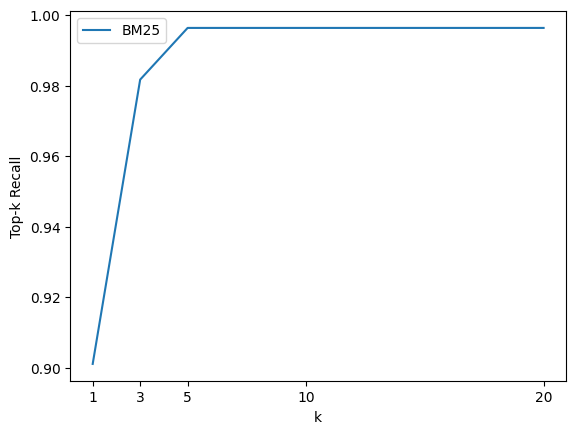

In [68]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

### DPR
In Haystack, we can initialize a retriever for DPR in a similar way to what we did for
BM25. In addition to specifying the document store, we also need to pick the BERT
encoders for the question and passage. These encoders are trained by giving them
questions with relevant (positive) passages and irrelevant (negative) passages, where
the goal is to learn that relevant question-passage pairs have a higher similarity. For
our use case, we’ll use encoders that have been fine-tuned on the NQ corpus in this
way:

In [69]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False) # Here we’ve also set embed_title=False since concatenating the document’s title (i.e., item_id) doesn’t provide any additional information because we filter per product.

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Once we’ve initialized the dense retriever, the next step is to iterate over all the
indexed documents in our Elasticsearch index and apply the encoders to update the
embedding representation. This can be done as follows:

In [70]:
document_store.update_embeddings(retriever=dpr_retriever)


Create embeddings: 100%|██████████| 1632/1632 [00:21<00:00, 88.64 Docs/s]
Updating embeddings: 10000 Docs [00:43, 227.61 Docs/s]


We’re now set to go! We can evaluate the dense retriever in the same way we did for
BM25 and compare the top-k recall:

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a c

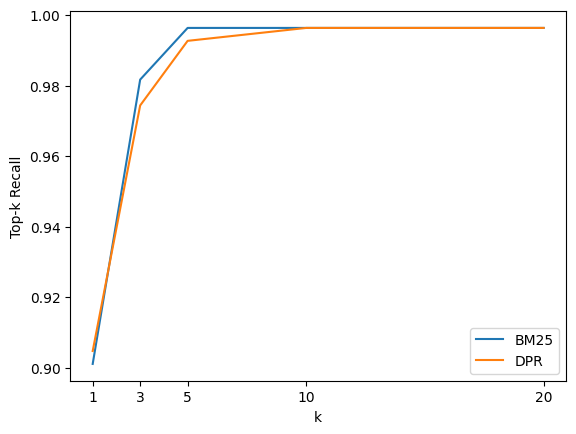

In [71]:
#  %%script false --no-raise-error
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

## Reader Evaluation
In extractive QA, there are two main metrics that are used for evaluating readers:
- Exact Match (EM): A binary metric that gives EM = 1 if the characters in the predicted and ground
truth answers match exactly, and EM = 0 otherwise. If no answer is expected, the
model gets EM = 0 if it predicts any text at all.
- F1-score: Measures the harmonic mean of the precision and recall.


The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the pipeline.eval() gets the relevant documents as direct input from the labels.

In [72]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In [73]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5677655677655677,
  'f1': 0.6123980271685507}}

See performance on SQuAD 2.0: https://huggingface.co/deepset/roberta-base-squad2-distilled

In [74]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()



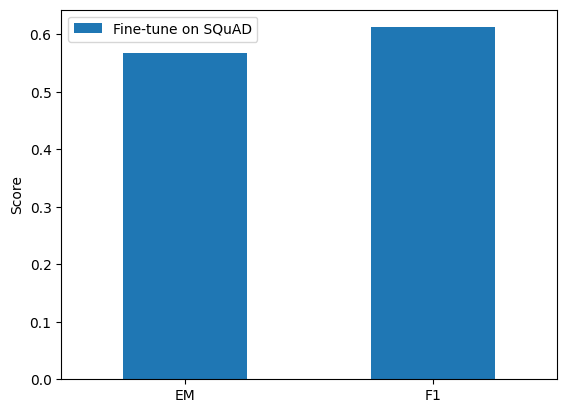

In [75]:
plot_reader_eval(reader_eval)


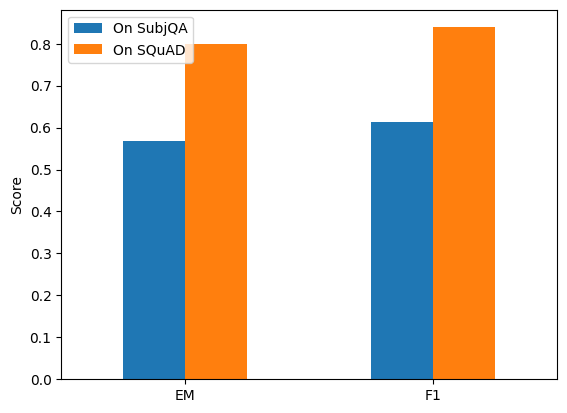

In [76]:
tmp = {'On SubjQA': {'exact_match': 0.5677655677655677,
  'f1': 0.6123980271685507},
 'On SQuAD': {'exact_match': 0.798366040596311,
  'f1': 0.83916407079888}}

plot_reader_eval(tmp)

### Reader Enhancement: Domain Adaptation


In [77]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [78]:
product = dfs["train"].query("title == '0310263662'")
create_paragraphs(product)

[{'qas': [{'question': 'How did you like the movie?',
    'id': '4593a383c6b34dc5b3862746cc792675',
    'is_impossible': True,
    'answers': []}],
  'context': 'Well, I have to admit I wasn\'t expecting to like this movie, having read all the bad press surrounding it.  But I saw it last night on a whim and I have to say I thought it was fantastic!  Firstly, as a movie it is incredibly well shot.  The scenery is wonderful and the sets are painstakingly recreated - never once do you doubt this is 1st century Palestine.The acting starts off a little strained in the garden scene, when the movie is just finding it\'s feet (and the audience is coming to terms with the fact that the movie isn\'t some horrible, cheap propaganda short, but a proper movie) but quickly becomes impressive and ends up brutally real.Gibson has set out to make a compelling dramatization of the last 12 hours of Jesus\' life as described in the Gospels and that\'s pretty much what he does.  There is certain artistic l

The final step is to then apply this function to each product ID in the DataFrame of
each split. The following convert_to_squad() function does this trick and stores the
result in an movies-{split}.json file

In [79]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"movies-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [80]:
##  #  %%script false --no-raise-error
from haystack.utils import EarlyStopping
es = EarlyStopping(metric="loss")
train_filename = "movies-train.json"
dev_filename = "movies-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=8, learning_rate=1e-5,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'made you who you are, and you use it to bleed even more and more money out of us.Palpatine would have been proud. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Preprocessing dataset:  33%|███▎      | 1/3 [00:01<00:02,  1.30s/ Dicts]WARNING:haystack.modeling.data_handler.processor:Answer 'The music, including the new song, is still outstanding.So what's my complaint?  It's the same one I have with the stage version.  The Phantom is made out to be sympathetic.  This is even truer here as we see his past as a little boy.  The problem is he's an evil man whose true nature comes out the more people stand up to him.  I realize I'm alone in not enjoying this glorification.  At least he does realize how bad his behav

In [81]:
#%%script false --no-raise-error

reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

In [82]:
#  %%script false --no-raise-error

reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5677655677655677,
  'f1': 0.6123980271685507},
 'Fine-tune on SQuAD + SubjQA': {'exact_match': 0.7032967032967034,
  'f1': 0.7032967032967034}}

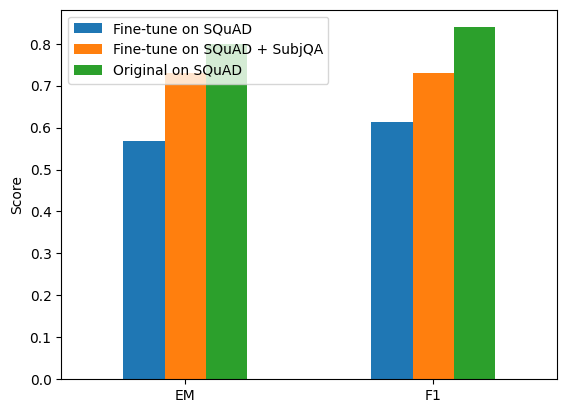

In [83]:
tmp = {'Fine-tune on SQuAD': {'exact_match': 0.5677655677655677,
  'f1': 0.6123980271685507},
 'Fine-tune on SQuAD + SubjQA': {'exact_match': 0.73,
  'f1': 0.73},
 'Original on SQuAD': {'exact_match': 0.798366040596311,
  'f1': 0.83916407079888}}

plot_reader_eval(tmp)


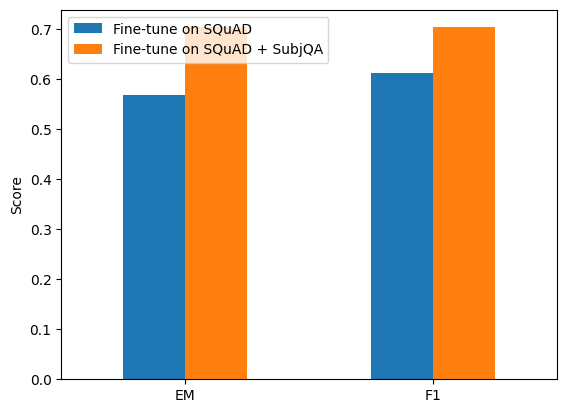

In [84]:
#  #  %%script false --no-raise-error
plot_reader_eval(reader_eval)

## Overall QA Pipeline Evaluation


In [95]:
#  %%script false --no-raise-error
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

In [96]:
# Each Pipeline has a run() method that specifies how the query flow should be exe‐
# cuted. For the ExtractiveQAPipeline we just need to pass the query, the number of
# documents to retrieve with top_k_retriever, and the number of answers to extract
# from these documents with top_k_reader. In our case, we also need to specify a filter
# over the item ID, which can be done using the filters argument as we did with the
# retriever earlier

n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")


Question: Who is Anakin Skywalker? 

Answer 1: 
Review snippet: ...None...



Answer 2: little 5-year-old
Review snippet: ...acting are extremely weak at times during the movie.  For example, little 5-year-old Anakin Skywalker hits on the Princess at many times during the mo...



Answer 3: the young Anakin Skywalker
Review snippet: ...is massive plan to take over the Republic into motion. We see the young Anakin Skywalker, who's fate is the evil Darth Vader, but who will eventually ...





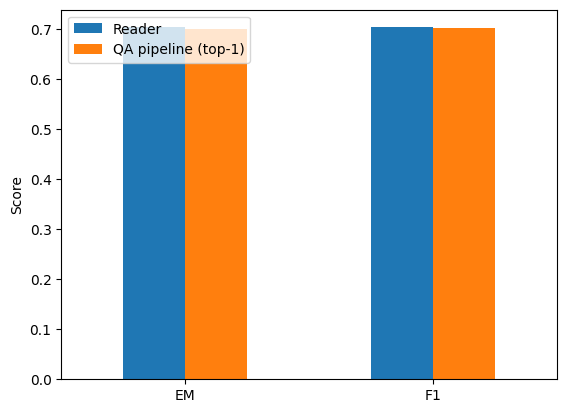

In [87]:
#  %%script false --no-raise-error
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

In [88]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5677655677655677,
  'f1': 0.6123980271685507},
 'Fine-tune on SQuAD + SubjQA': {'exact_match': 0.7032967032967034,
  'f1': 0.7032967032967034},
 'QA Pipeline (top-1)': {'exact_match': 0.6996336996336996,
  'f1': 0.7017268445839874}}

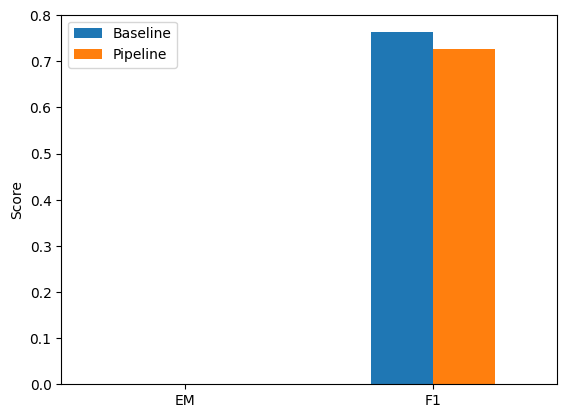

In [89]:
plot_reader_eval({'Baseline': {'f1': 0.763},
 'Pipeline': {'f1': 0.727}})

# Advancing with Generative QA: Retrieval-Augmented Generation (RAG)


As of version 1.16, RAGenerator has been deprecated in Haystack and completely removed from Haystack as of v1.18. We recommend following the tutorial on Creating a Generative QA Pipeline with Retrieval-Augmentation instead. For more details about this deprecation, check out our announcement on Github.

https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/07_RAG_Generator.ipynb

In [90]:
##  #  %%script false --no-raise-error
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser

rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
                             Provide a clear and concise response that summarizes the key points and information presented in the text.
                             Your answer should be in your own words and be no longer than 50 words.
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

prompt_node = PromptNode(model_name_or_path="google/flan-t5-large", default_prompt_template=rag_prompt, max_length=512, model_kwargs={"model_max_length": 5120})
#The max_length parameter in PromptNode only sets the maximum number of tokens for the generated text output. Therefore, take the potential token length of the prompt into account when setting the parameter. The token length of the prompt plus the specified max_length together must not be larger than the overall number of tokens the LLM can process.



In [91]:
bm25_retriever = BM25Retriever(document_store=document_store, top_k=5)

In [92]:
##  #  %%script false --no-raise-error
from haystack.pipelines import Pipeline

pipe = Pipeline()
pipe.add_node(component=bm25_retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

In [93]:
##  #  %%script false --no-raise-error

query = "Who is Anakin Skywalker?"

output = pipe.run(query=query)

print(output["answers"][0].answer)

The character is a Jedi Knight.
